In [2]:
# C:\Mark\uni\Uni Work\5th Year\Diss\ROC Surfaces\adni_noNA.csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib notebook

# The data

In [2]:
df = pd.read_csv('C:\\Mark\\uni\\Uni Work\\5th Year\\Diss\\ROC Surfaces\\adni_noNA.csv')
df

,Unnamed: 0,RID,APOE4,MMSE,age,gender,educ,DX,abeta,tau,LeftHipp,RightHipp,Hipp,HCI
0,1,2002,0,28,65,1,16,2,293,254,3.919,4.041,7.960,8.5163
1,2,2002,0,28,65,1,16,2,293,254,3.803,4.033,7.836,8.5163
2,3,2010,1,30,63,2,20,2,444,729,4.045,3.957,8.002,4.9071
3,4,2010,1,30,63,2,20,2,444,729,4.001,4.003,8.004,4.9071
4,5,2018,0,29,76,2,18,2,500,559,3.789,3.965,7.754,8.7040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,1030,5290,1,29,67,2,12,1,1808,1620,3.782,3.759,7.541,4.9309
1028,1031,5292,0,30,74,2,13,1,1850,1330,3.397,3.705,7.102,6.8485
1029,1032,5295,1,29,75,2,15,1,802,1792,2.657,3.271,5.928,18.9298
1030,1033,5296,0,29,69,1,14,1,270,569,5.140,5.392,10.532,10.1158


In [3]:
d1 = df[df['DX'] == 1]
d2 = df[df['DX'] == 2]
d3 = df[df['DX'] == 3]

In [4]:
def ROCSurfaceEmp(d1, d2, d3, marker, reverse=False, log=False):
    marker_1 = np.array(d1[marker])
    marker_2 = np.array(d2[marker])
    marker_3 = np.array(d3[marker])
    
    if log:
        marker_1 = np.log(marker_1)
        marker_2 = np.log(marker_2)
        marker_3 = np.log(marker_3)
    
    if reverse:
        marker_1 = [-i for i in marker_1]
        marker_2 = [-i for i in marker_2]
        marker_3 = [-i for i in marker_3]
    
    mu1d, sigma1d = np.mean(marker_1), np.std(marker_1)
    mu2d, sigma2d = np.mean(marker_2), np.std(marker_2)
    mu3d, sigma3d = np.mean(marker_3), np.std(marker_3)
    
    p1 = np.linspace(0,1,100)
    p3 = np.linspace(0,1,100)

    a = (mu3d - mu2d) / sigma2d
    b = sigma3d / sigma2d

    c = (mu1d - mu2d) / sigma2d
    d = sigma1d / sigma2d
    
    ecdf = ECDF(marker_2) 

    ROCsurface = []
    ROCsurface2 = []

    for i in p1:
        nowlist = []
        nowlist2 = []
        for j in p3:
            rocsurface_here = ecdf(np.quantile(marker_3, 1-j)) - ecdf(np.quantile(marker_1, i))

            if rocsurface_here >=0:
                nowlist.append(rocsurface_here)
                nowlist2.append(rocsurface_here)
            else:
                nowlist.append(0)
                nowlist2.append(np.nan)
        ROCsurface.append(nowlist)
        ROCsurface2.append(nowlist2)
        
    first = [ROCsurface[i][j] for i in range(100) for j in range(100)]
    VUS = np.nanmean(first)
    
    #ROCsurface2 = [np.nan if i == 0 else i for i in ROCsurface[j] for j in range(100)]
    
    return p1, ROCsurface, p3, VUS, ROCsurface2

# Example Empirical ROC for Abeta - No Covariates

<IPython.core.display.Javascript object>


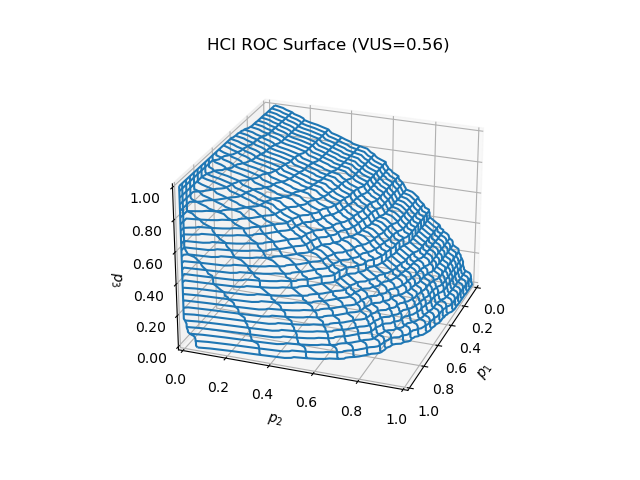

In [5]:
marker = 'HCI'

x, Y, z, VUS, Y2 = ROCSurfaceEmp(d1, d2, d3, marker, log=False) 

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X, Z = np.meshgrid(x, z)

surf = ax.plot_wireframe(X, Y, Z, rstride=4, cstride=4)

ax.zaxis.set_major_formatter('{x:.02f}')

ax.set_title(f"{marker} ROC Surface (VUS={round(VUS, 3)})")

ax.set_xlabel("$p_1$")
ax.set_xlim(0,1)

ax.set_ylabel("$p_2$")
ax.set_ylim(0,1)

ax.set_zlabel("$p_3$")
ax.set_zlim(0,1)

ax.view_init(elev=25, azim=20)

plt.show()

# Covariate - Age

First we must investigate the data

<IPython.core.display.Javascript object>


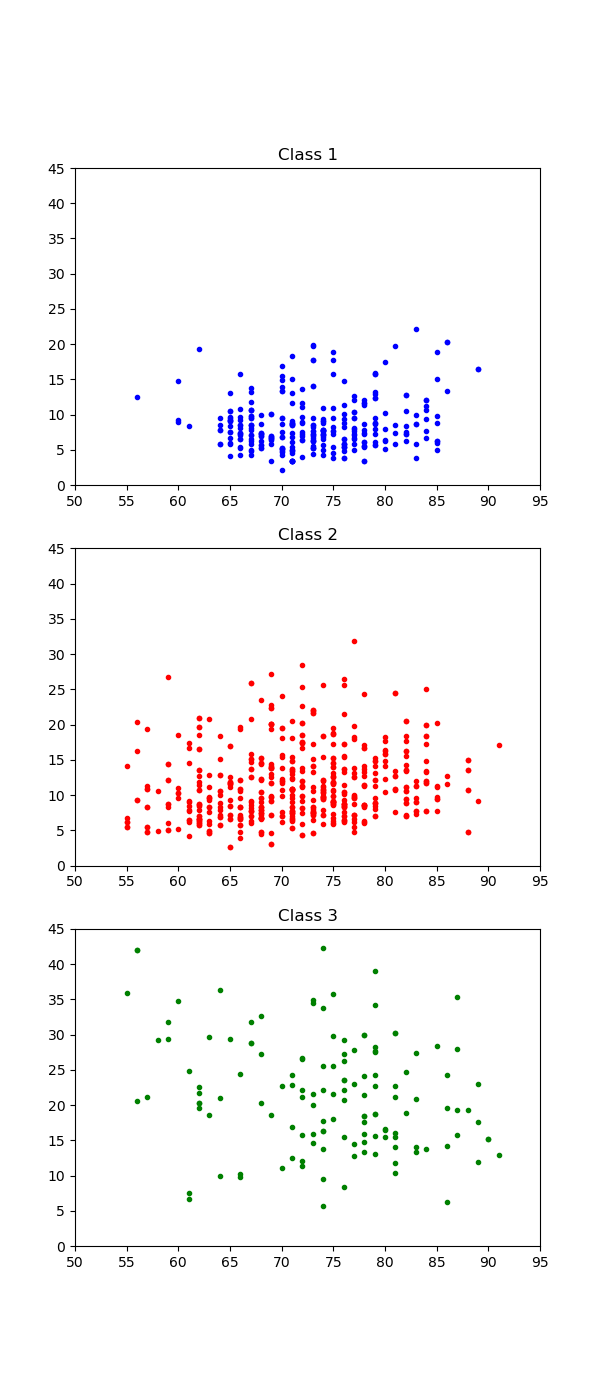

In [8]:
fig, ax = plt.subplots(3,1, figsize=(6,14))

for i in ax:
    i.set_ylim(0,45)
    i.set_xlim(50,95)

ax[0].plot(d1['age'], d1[marker], 'b.')
ax[0].set_title('Class 1')
ax[1].plot(d2['age'], d2[marker], 'r.')
ax[1].set_title('Class 2')
ax[2].plot(d3['age'], d3[marker], 'g.')
ax[2].set_title('Class 3')

plt.show()

### Linear Models

In [9]:
from sklearn.linear_model import LinearRegression

# Pick out only the marker values
d1_marker = np.array(d1[marker])
d2_marker = np.array(d2[marker])
d3_marker = np.array(d3[marker])

# Pick out only the ages
d1_age= np.array(d1['age'])
d2_age= np.array(d2['age'])
d3_age= np.array(d3['age'])

# Reshape the data to work with sklearn
d1_age = d1_age.reshape(-1, 1)
d1_marker = d1_marker.reshape(-1, 1)

d2_age = d2_age.reshape(-1, 1)
d2_marker = d2_marker.reshape(-1, 1)

d3_age = d3_age.reshape(-1, 1)
d3_marker = d3_marker.reshape(-1, 1)

# Fit the linear model and find the parameters and the standard residual error for healthy
regd1 = LinearRegression().fit(d1_age, d1_marker)
beta1 = [regd1.intercept_[0], regd1.coef_[0][0]]
# Calculate sigma hat
yd1_hat = regd1.predict(d1_age)
residualsd1 = d1_marker - yd1_hat
residual_sum_of_squaresd1 = residualsd1.T @ residualsd1
sigmad1 = np.sqrt(residual_sum_of_squaresd1/(len(d1_marker)-2))

# Fit the linear model and find the parameters and the standard residual error for healthy
regd2 = LinearRegression().fit(d2_age, d2_marker)
beta2 = [regd2.intercept_[0], regd2.coef_[0][0]]
# Calculate sigma hat
yd2_hat = regd2.predict(d2_age)
residualsd2 = d2_marker - yd2_hat
residual_sum_of_squaresd2 = residualsd2.T @ residualsd2
sigmad2 = np.sqrt(residual_sum_of_squaresd2/(len(d2_marker)-2))

# Fit the linear model and find the parameters and the standard residual error for healthy
regd3 = LinearRegression().fit(d3_age, d3_marker)
beta3 = [regd3.intercept_[0], regd3.coef_[0][0]]
# Calculate sigma hat
yd3_hat = regd3.predict(d3_age)
residualsd3 = d3_marker - yd3_hat
residual_sum_of_squaresd3 = residualsd3.T @ residualsd3
sigmad3 = np.sqrt(residual_sum_of_squaresd3/(len(d3_marker)-2))

<IPython.core.display.Javascript object>


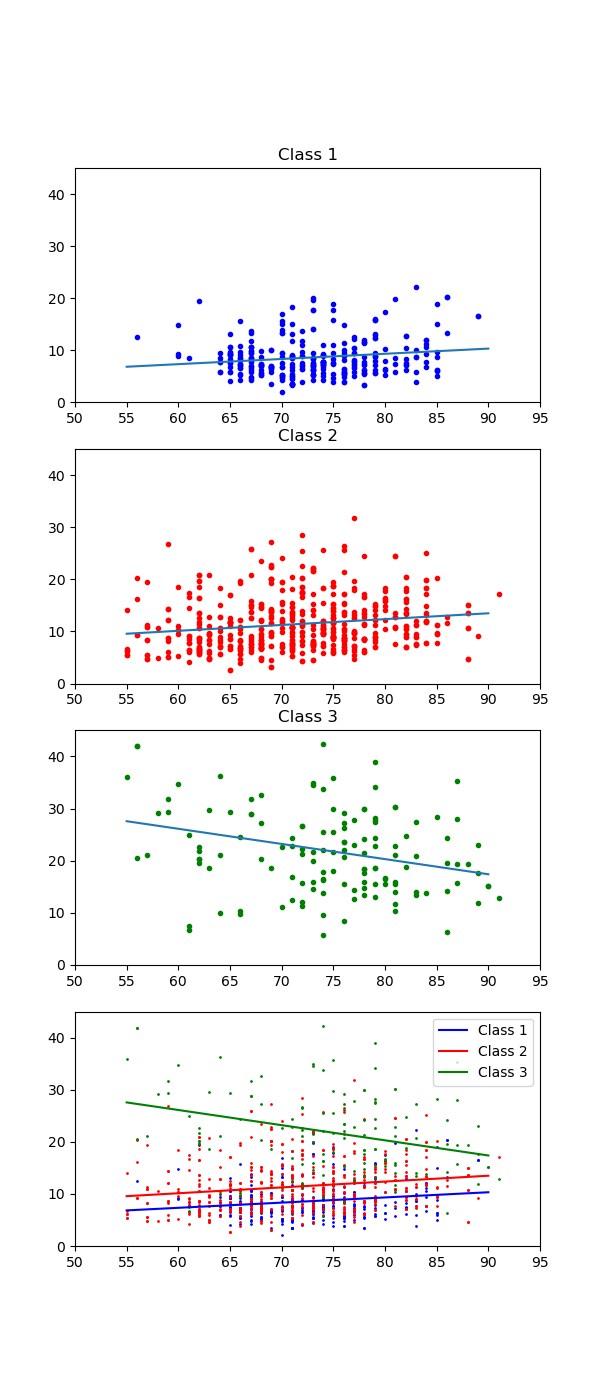

In [15]:
fig, ax = plt.subplots(4,1, figsize=(6,14))

for i in ax:
    i.set_ylim(0,45)
    i.set_xlim(50,95)

o = np.linspace(55,90,71).reshape(-1, 1)
    
ax[0].plot(d1['age'], d1[marker], 'b.')
ax[0].plot(o, regd1.predict(o))
ax[0].set_title('Class 1')


ax[1].plot(d2['age'], d2[marker], 'r.')
ax[1].plot(o, regd2.predict(o))
ax[1].set_title('Class 2')


ax[2].plot(d3['age'], d3[marker], 'g.')
ax[2].plot(o, regd3.predict(o))
ax[2].set_title('Class 3')

ax[3].plot(d1['age'], d1[marker], 'b.', markersize=2)
ax[3].plot(d2['age'], d2[marker], 'r.', markersize=2)
ax[3].plot(d3['age'], d3[marker], 'g.', markersize=2)
ax[3].plot(o, regd1.predict(o), 'b-', label='Class 1')
ax[3].plot(o, regd2.predict(o), 'r-', label='Class 2')
ax[3].plot(o, regd3.predict(o), 'g-', label='Class 3')
ax[3].legend()

plt.show()

### Covariate ROC Surfaces

In [12]:
p1 = np.linspace(0,1,101)
p3 = np.linspace(0,1,101)

age_grid = np.linspace(55,90,36)

Xpred = np.array([[1, i] for i in age_grid])

mu1_pred = Xpred @ np.array(beta1)
mu2_pred = Xpred @ np.array(beta2)
mu3_pred = Xpred @ np.array(beta3)

roc_age_est = {}
vus_age_est = {}
# Fit the ECDF to the standardised residuals of the diseased population

ecdf = ECDF([i[0] for i in residualsd2/sigmad2[0][0]])

for k in range(len(age_grid)):    
    a = (mu3_pred[k] - mu2_pred[k]) / sigmad2[0][0]
    b = sigmad3[0][0] / sigmad3[0][0]

    c = (mu1_pred[k] - mu2_pred[k]) / sigmad2[0][0]
    d = sigmad3[0][0] / sigmad2[0][0]
    
    ROC_surface = []
    
    for i in p1:
        nowlist = []
        for j in p3:
            roc_now = ecdf(a + b*np.quantile(residualsd3/sigmad3[0][0], 1-j)) - ecdf(c+d*np.quantile(residualsd1/sigmad1[0][0], i))
            
            if roc_now >= 0:
                nowlist.append(roc_now)
            else:
                nowlist.append(0)
                
        ROC_surface.append(nowlist)
    
    first = [ROC_surface[i][j] for i in range(101) for j in range(101)]
    VUS = np.nanmean(first)
    
    roc_age_est[f'Age: {k+55}'] = ROC_surface
    vus_age_est[f'Age: {k+55}'] = VUS
    print(f'Age: {k+55}')

Age: 55
Age: 56
Age: 57
Age: 58
Age: 59
Age: 60
Age: 61
Age: 62
Age: 63
Age: 64
Age: 65
Age: 66
Age: 67
Age: 68
Age: 69
Age: 70
Age: 71
Age: 72
Age: 73
Age: 74
Age: 75
Age: 76
Age: 77
Age: 78
Age: 79
Age: 80
Age: 81
Age: 82
Age: 83
Age: 84
Age: 85
Age: 86
Age: 87
Age: 88
Age: 89
Age: 90


In [13]:
roc_age_est.keys()

dict_keys(['Age: 55', 'Age: 56', 'Age: 57', 'Age: 58', 'Age: 59', 'Age: 60', 'Age: 61', 'Age: 62', 'Age: 63', 'Age: 64', 'Age: 65', 'Age: 66', 'Age: 67', 'Age: 68', 'Age: 69', 'Age: 70', 'Age: 71', 'Age: 72', 'Age: 73', 'Age: 74', 'Age: 75', 'Age: 76', 'Age: 77', 'Age: 78', 'Age: 79', 'Age: 80', 'Age: 81', 'Age: 82', 'Age: 83', 'Age: 84', 'Age: 85', 'Age: 86', 'Age: 87', 'Age: 88', 'Age: 89', 'Age: 90'])

<IPython.core.display.Javascript object>


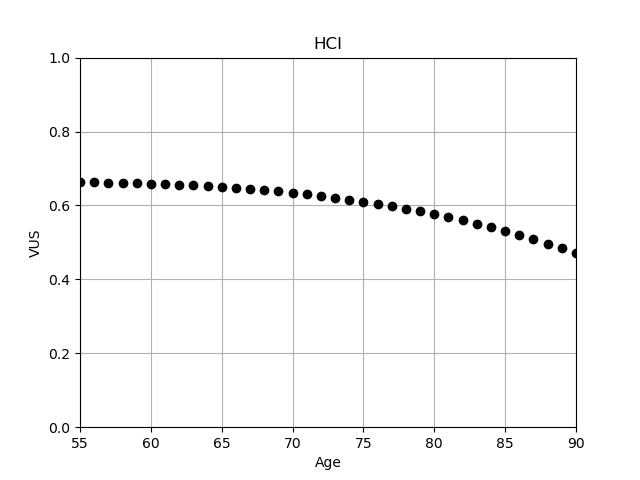

In [25]:
plt.plot(age_grid, vus_age_est.values(), 'ko')
plt.ylim(0,1)
plt.xlim(55,90)
plt.title(marker)
plt.xlabel('Age')
plt.ylabel('VUS')
plt.grid(visible=True)
plt.show()

<IPython.core.display.Javascript object>


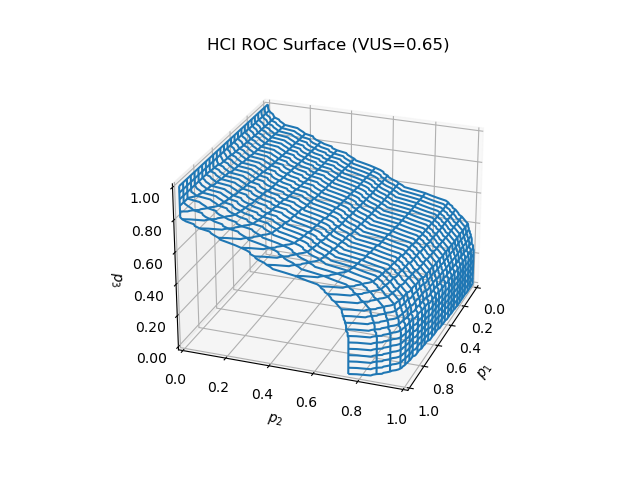

In [17]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

p1 = np.linspace(0,1,101)
p3 = np.linspace(0,1,101)

age = 'Age: 65'

x, z = np.meshgrid(p1, p3)

surf = ax.plot_wireframe(x, roc_age_est[age], z, rstride=4, cstride=4)

ax.zaxis.set_major_formatter('{x:.02f}')

ax.set_title(f"{marker} ROC Surface (VUS={round(vus_age_est[age], 3)})")

ax.set_xlabel("$p_1$")
ax.set_xlim(0,1)

ax.set_ylabel("$p_2$")
ax.set_ylim(0,1)

ax.set_zlabel("$p_3$")
ax.set_zlim(0,1)

ax.view_init(elev=25, azim=20)

plt.show()

In [18]:
def ROCEmpPlotAge(age= 'Age: 55'):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    p1 = np.linspace(0,1,101)
    p3 = np.linspace(0,1,101)

    x, z = np.meshgrid(p1, p3)

    surf = ax.plot_wireframe(x, roc_age_est[age], z, rstride=4, cstride=4)

    ax.zaxis.set_major_formatter('{x:.02f}')

    ax.set_title(f"{age} - {marker} ROC Surface (VUS={round(vus_age_est[age], 3)})")

    ax.set_xlabel("$p_1$")
    ax.set_xlim(0,1)

    ax.set_ylabel("$p_2$")
    ax.set_ylim(0,1)

    ax.set_zlabel("$p_3$")
    ax.set_zlim(0,1)

    ax.view_init(elev=25, azim=20)

    plt.show()

<IPython.core.display.Javascript object>


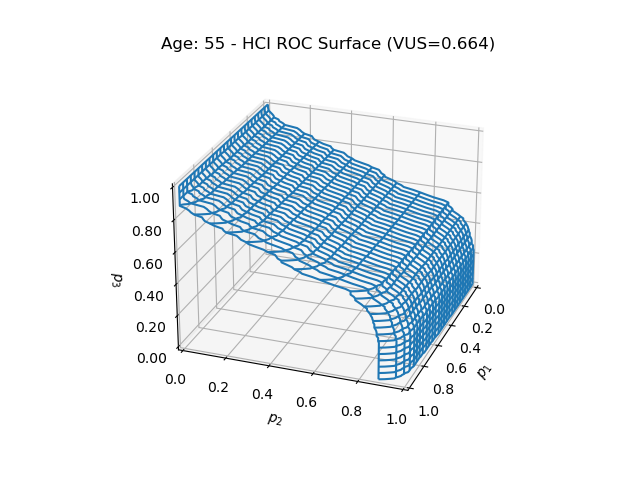

In [19]:
ROCEmpPlotAge(age='Age: 55')

<IPython.core.display.Javascript object>


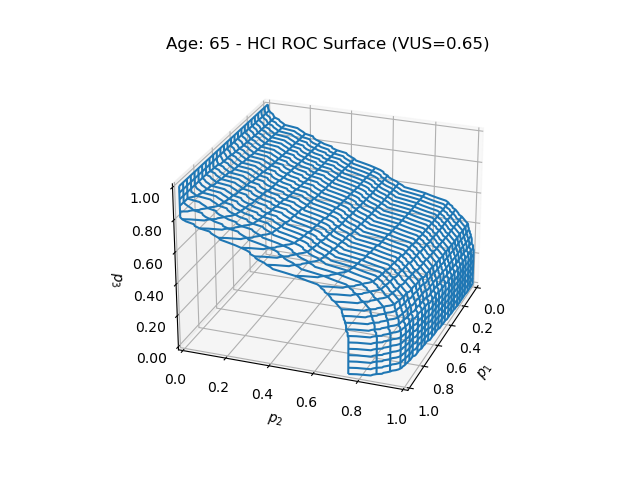

In [20]:
ROCEmpPlotAge(age='Age: 65')

<IPython.core.display.Javascript object>


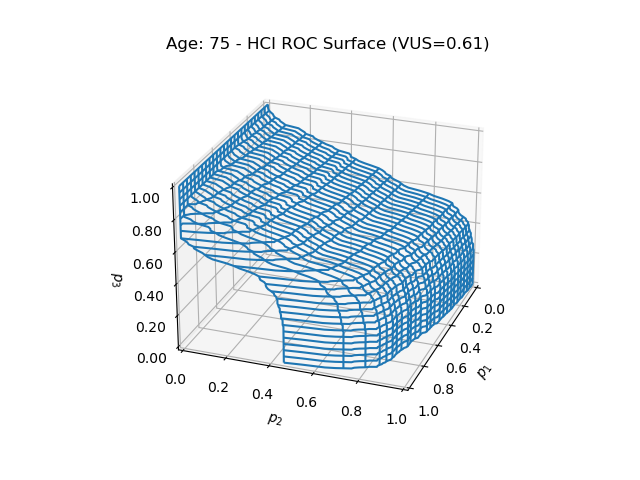

In [21]:
ROCEmpPlotAge(age='Age: 75')

<IPython.core.display.Javascript object>


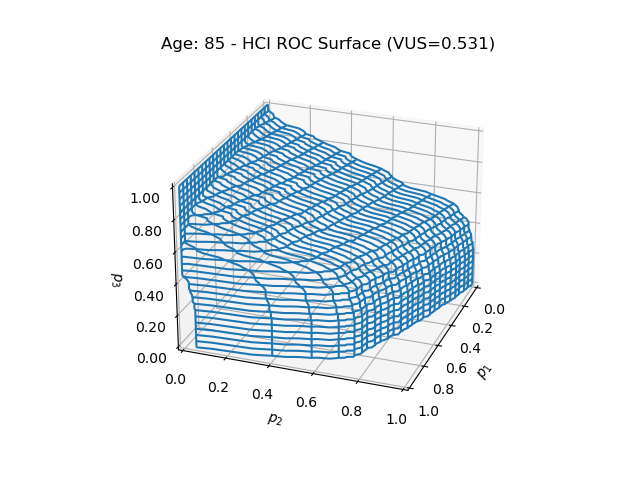

In [22]:
ROCEmpPlotAge(age='Age: 85')

<IPython.core.display.Javascript object>


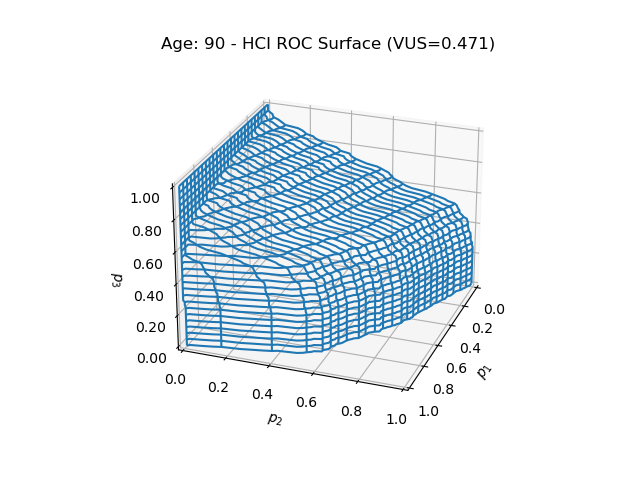

In [23]:
ROCEmpPlotAge(age='Age: 90')

# Bootstrap 

First we find the non-bootstrapped VUSs

In [3]:
from sklearn.linear_model import LinearRegression

marker = 'HCI'

df = pd.read_csv('C:\\Mark\\uni\\Uni Work\\5th Year\\Diss\\ROC Surfaces\\adni_noNA.csv')
data_len = df.shape[0]

d1 = df[df['DX'] == 1]
d2 = df[df['DX'] == 2]
d3 = df[df['DX'] == 3]

# Pick out only the marker values
d1_marker = np.array(d1[marker])
d2_marker = np.array(d2[marker])
d3_marker = np.array(d3[marker])

# Pick out only the ages
d1_age= np.array(d1['age'])
d2_age= np.array(d2['age'])
d3_age= np.array(d3['age'])

# Reshape the data to work with sklearn
d1_age = d1_age.reshape(-1, 1)
d1_marker = d1_marker.reshape(-1, 1)

d2_age = d2_age.reshape(-1, 1)
d2_marker = d2_marker.reshape(-1, 1)

d3_age = d3_age.reshape(-1, 1)
d3_marker = d3_marker.reshape(-1, 1)

# Fit the linear model and find the parameters and the standard residual error for healthy
regd1 = LinearRegression().fit(d1_age, d1_marker)
beta1 = [regd1.intercept_[0], regd1.coef_[0][0]]
# Calculate sigma hat
yd1_hat = regd1.predict(d1_age)
residualsd1 = d1_marker - yd1_hat
residual_sum_of_squaresd1 = residualsd1.T @ residualsd1
sigmad1 = np.sqrt(residual_sum_of_squaresd1/(len(d1_marker)-2))

# Fit the linear model and find the parameters and the standard residual error for healthy
regd2 = LinearRegression().fit(d2_age, d2_marker)
beta2 = [regd2.intercept_[0], regd2.coef_[0][0]]
# Calculate sigma hat
yd2_hat = regd2.predict(d2_age)
residualsd2 = d2_marker - yd2_hat
residual_sum_of_squaresd2 = residualsd2.T @ residualsd2
sigmad2 = np.sqrt(residual_sum_of_squaresd2/(len(d2_marker)-2))

# Fit the linear model and find the parameters and the standard residual error for healthy
regd3 = LinearRegression().fit(d3_age, d3_marker)
beta3 = [regd3.intercept_[0], regd3.coef_[0][0]]
# Calculate sigma hat
yd3_hat = regd3.predict(d3_age)
residualsd3 = d3_marker - yd3_hat
residual_sum_of_squaresd3 = residualsd3.T @ residualsd3
sigmad3 = np.sqrt(residual_sum_of_squaresd3/(len(d3_marker)-2))

p1 = np.linspace(0,1,101)
p3 = np.linspace(0,1,101)

age_grid = np.linspace(55,90,36)

Xpred = np.array([[1, i] for i in age_grid])

mu1_pred = Xpred @ np.array(beta1)
mu2_pred = Xpred @ np.array(beta2)
mu3_pred = Xpred @ np.array(beta3)

roc_age_est = {}
vus_age_est_orig = {}
# Fit the ECDF to the standardised residuals of the diseased population

ecdf = ECDF([i[0] for i in residualsd2/sigmad2[0][0]])

for k in range(len(age_grid)):    
    a = (mu3_pred[k] - mu2_pred[k]) / sigmad2[0][0]
    b = sigmad3[0][0] / sigmad3[0][0]

    c = (mu1_pred[k] - mu2_pred[k]) / sigmad2[0][0]
    d = sigmad3[0][0] / sigmad2[0][0]
    
    ROC_surface = []
    
    for i in p1:
        nowlist = []
        for j in p3:
            roc_now = ecdf(a + b*np.quantile(residualsd3/sigmad3[0][0], 1-j)) - ecdf(c+d*np.quantile(residualsd1/sigmad1[0][0], i))
            
            if roc_now >= 0:
                nowlist.append(roc_now)
            else:
                nowlist.append(0)
                
        ROC_surface.append(nowlist)
    
    first = [ROC_surface[i][j] for i in range(101) for j in range(101)]
    VUS = np.nanmean(first)
    
    roc_age_est[f'Age: {k+55}'] = ROC_surface
    vus_age_est_orig[f'Age: {k+55}'] = VUS
    print(f'Age: {k+55}')

Age: 55
Age: 56
Age: 57
Age: 58
Age: 59
Age: 60
Age: 61
Age: 62
Age: 63
Age: 64
Age: 65
Age: 66
Age: 67
Age: 68
Age: 69
Age: 70
Age: 71
Age: 72
Age: 73
Age: 74
Age: 75
Age: 76
Age: 77
Age: 78
Age: 79
Age: 80
Age: 81
Age: 82
Age: 83
Age: 84
Age: 85
Age: 86
Age: 87
Age: 88
Age: 89
Age: 90


<IPython.core.display.Javascript object>


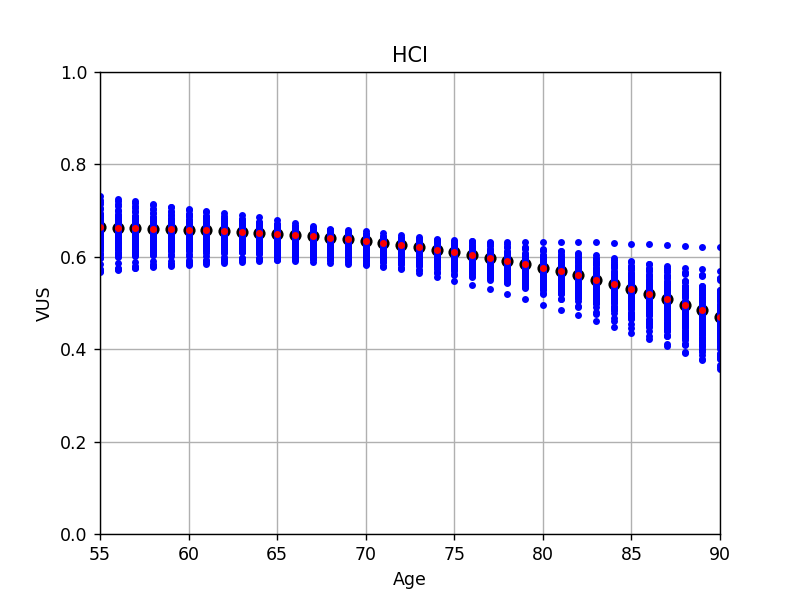

In [4]:
plt.plot(age_grid, [i for i in vus_age_est_orig.values()], 'ko')
plt.ylim(0,1)
plt.xlim(55,90)
plt.title(marker)
plt.xlabel('Age')
plt.ylabel('VUS')
plt.grid(visible=True)
plt.show()

In [ ]:
"""
BOOTSTRAPPING BELOW
"""

df = pd.read_csv('C:\\Mark\\uni\\Uni Work\\5th Year\\Diss\\ROC Surfaces\\adni_noNA.csv')
data_len = df.shape[0]

VUSs = []
ROCs = []

gridsize = 25
bootstrapsize = 500

for counter in range(bootstrapsize):
    rdf = df.sample(n=data_len, replace=True)
    
    d1 = rdf[rdf['DX'] == 1]
    d2 = rdf[rdf['DX'] == 2]
    d3 = rdf[rdf['DX'] == 3]

    # Pick out only the marker values
    d1_marker = np.array(d1[marker])
    d2_marker = np.array(d2[marker])
    d3_marker = np.array(d3[marker])

    # Pick out only the ages
    d1_age= np.array(d1['age'])
    d2_age= np.array(d2['age'])
    d3_age= np.array(d3['age'])

    # Reshape the data to work with sklearn
    d1_age = d1_age.reshape(-1, 1)
    d1_marker = d1_marker.reshape(-1, 1)

    d2_age = d2_age.reshape(-1, 1)
    d2_marker = d2_marker.reshape(-1, 1)

    d3_age = d3_age.reshape(-1, 1)
    d3_marker = d3_marker.reshape(-1, 1)

    # Fit the linear model and find the parameters and the standard residual error for healthy
    regd1 = LinearRegression().fit(d1_age, d1_marker)
    beta1 = [regd1.intercept_[0], regd1.coef_[0][0]]
    # Calculate sigma hat
    yd1_hat = regd1.predict(d1_age)
    residualsd1 = d1_marker - yd1_hat
    residual_sum_of_squaresd1 = residualsd1.T @ residualsd1
    sigmad1 = np.sqrt(residual_sum_of_squaresd1/(len(d1_marker)-2))

    # Fit the linear model and find the parameters and the standard residual error for healthy
    regd2 = LinearRegression().fit(d2_age, d2_marker)
    beta2 = [regd2.intercept_[0], regd2.coef_[0][0]]
    # Calculate sigma hat
    yd2_hat = regd2.predict(d2_age)
    residualsd2 = d2_marker - yd2_hat
    residual_sum_of_squaresd2 = residualsd2.T @ residualsd2
    sigmad2 = np.sqrt(residual_sum_of_squaresd2/(len(d2_marker)-2))

    # Fit the linear model and find the parameters and the standard residual error for healthy
    regd3 = LinearRegression().fit(d3_age, d3_marker)
    beta3 = [regd3.intercept_[0], regd3.coef_[0][0]]
    # Calculate sigma hat
    yd3_hat = regd3.predict(d3_age)
    residualsd3 = d3_marker - yd3_hat
    residual_sum_of_squaresd3 = residualsd3.T @ residualsd3
    sigmad3 = np.sqrt(residual_sum_of_squaresd3/(len(d3_marker)-2))
    
    p1 = np.linspace(0,1,gridsize)
    p3 = np.linspace(0,1,gridsize)

    #age_grid = np.arange(55,60)
    age_grid = np.arange(55,91)

    Xpred = np.array([[1, i] for i in age_grid])

    mu1_pred = Xpred @ np.array(beta1)
    mu2_pred = Xpred @ np.array(beta2)
    mu3_pred = Xpred @ np.array(beta3)

    roc_age_est = {}
    vus_age_est = {}
    # Fit the ECDF to the standardised residuals of the diseased population

    ecdf = ECDF([i[0] for i in residualsd2/sigmad2[0][0]])

    for k in range(len(age_grid)):    
        a = (mu3_pred[k] - mu2_pred[k]) / sigmad2[0][0]
        b = sigmad3[0][0] / sigmad3[0][0]

        c = (mu1_pred[k] - mu2_pred[k]) / sigmad2[0][0]
        d = sigmad3[0][0] / sigmad2[0][0]

        ROC_surface = []

        for i in p1:
            nowlist = []
            for j in p3:
                roc_now = ecdf(a + b*np.quantile(residualsd3/sigmad3[0][0], 1-j)) - ecdf(c+d*np.quantile(residualsd1/sigmad1[0][0], i))

                if roc_now >= 0:
                    nowlist.append(roc_now)
                else:
                    nowlist.append(0)

            ROC_surface.append(nowlist)

        first = [ROC_surface[i][j] for i in range(gridsize) for j in range(gridsize)]
        VUS = np.nanmean(first)

        #roc_age_est[f'Age: {k+55}'] = ROC_surface
        vus_age_est[f'Age: {k+55}'] = VUS
        
    #ROCs.append(roc_age_est)
    VUSs.append(vus_age_est)
        
    if counter % 10 == 0:
        print(counter)

In [6]:
for i in VUSs:
    plt.plot(age_grid, i.values(), 'b.')
    
plt.plot(age_grid, [i for i in vus_age_est_orig.values()], 'r.')
plt.ylim(0,1)
plt.xlim(55,90)
plt.title(marker)
plt.xlabel('Age')
plt.ylabel('VUS')
plt.grid(visible=True)
plt.show()

<IPython.core.display.Javascript object>


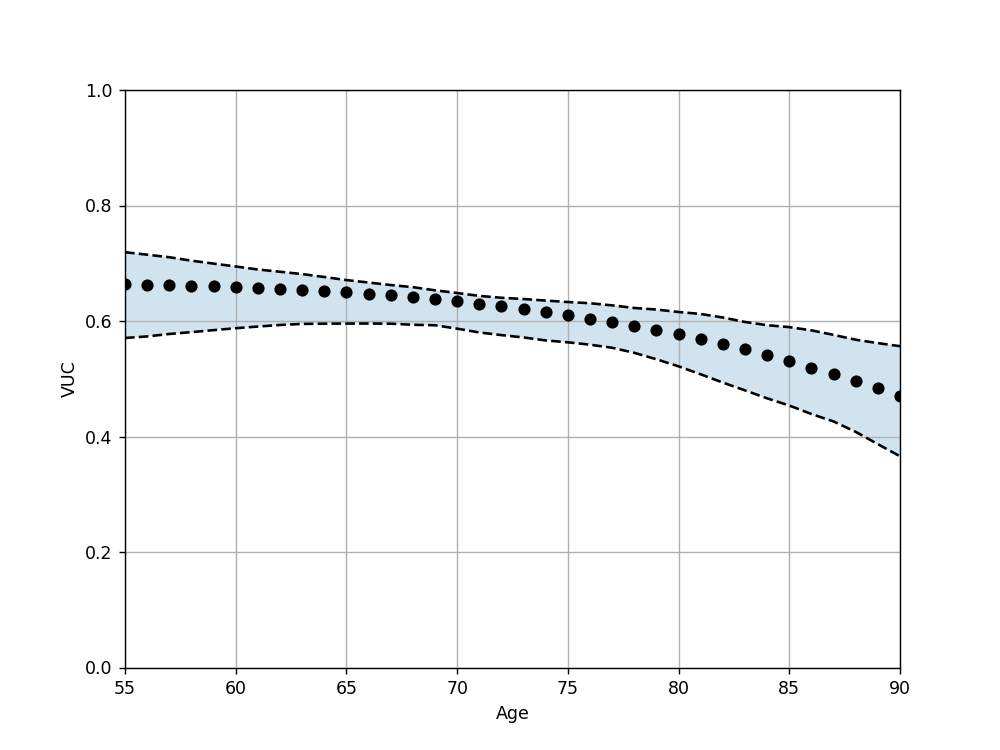

In [7]:
VUSs2 = np.array([np.array(list(i.values())) for i in VUSs])

VUC975s = []
VUC25s = []
VUSs_now = []

for i in range(len(age_grid)):
    VUSs_at_age_i = VUSs2[:,i]
    
    VUC975 = stats.mstats.mquantiles(VUSs_at_age_i, 0.975)
    VUC25 = stats.mstats.mquantiles(VUSs_at_age_i, 0.025)

    VUC975s.append(VUC975)
    VUC25s.append(VUC25)

VUC25s = [i[0] for i in VUC25s]
VUC975s = [i[0] for i in VUC975s]

plt.figure(figsize=(8,6))
# for i in VUSs:
#     plt.plot(age_grid, i.values(), 'b.')

plt.plot(age_grid, VUC975s, 'k--')
plt.plot(age_grid, VUC25s, 'k--')
plt.fill_between(age_grid, VUC25s, VUC975s, alpha=0.2)
plt.plot(age_grid, [i for i in vus_age_est_orig.values()], 'ko')
plt.grid(visible=True)
plt.xlim(55,90)
plt.xlabel('Age')
plt.ylabel('VUC')
plt.ylim(0,1)
plt.show()